In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

import sys
sys.path.append("../pyLib")
from phase_space_characterization import characterize_phase_space_at_septum

### Import CNAO Lattice to Xsuite

In [3]:
line = xt.Line.from_json('../templates/PIMMStutorials_CNAOlattice/cnao_lattice_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/429 [00:00<?, ?it/s]

Done loading line from dict.           


### Set tunes, chromaticities and zero dispersion at symmetry point

In [4]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-1, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.667, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 0.03          
Matching: model call n. 15               
Optimize - end penalty:  2.22037e-07


### Plot and calculate quantities for different initial delta

In [5]:
# Define initial momentum deviation
d_gen = -1e-3

# Twiss
tw = line.twiss(method='4d')

# Initial x range
x_first = tw.dx[0] * d_gen              # tw.dx[0] --> Dispersion at the first element (electrostatic septum)
x_last = tw.dx[0] * d_gen + 2.5e-2

# Initial px 
px_init = tw.dpx[0] * d_gen

# Generate defined number of particles 
num_particles = 20
x_gen = np.linspace(x_first, x_last, num_particles)

# Define number of turns
num_turns = 2000

/home/aefstrat/miniforge3/lib/python3.12/site-packages/xtrack/twiss.py:3238: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


      Computed quantities for delta = -1e-03:

intersection_point = (0.035, 0.0012587613125476177)
dpx_dx_at_septum = 2.472e-02
stable_area = 3.963e-06 * π

x_fp = [-0.00767554  0.00803426 -0.01213352]
px_fp = [-0.00767554  0.00803426 -0.01213352]
x_norm_fp = [-0.00096424  0.00302915 -0.00209744]
px_norm_fp = [-0.00096424  0.00302915 -0.00209744]



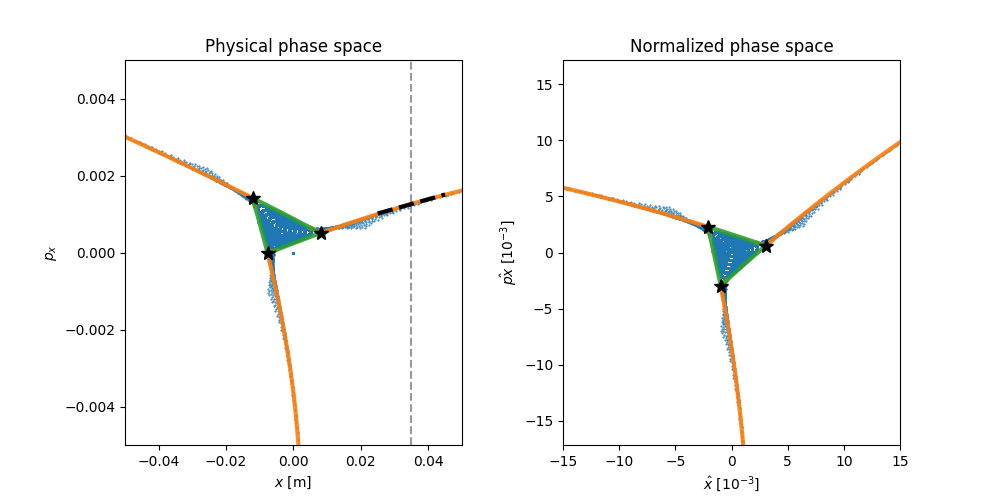

In [6]:
# Mark septum position
x_septum = 3.5e-2

# Call the function for calculating quantities and plotting phase space
# and store caclulated quantities on a dictionary
values = characterize_phase_space_at_septum(line, x_gen=x_gen, px_gen=px_init, d_gen=d_gen, xBoundary=x_septum, plot=True)

# Calculate stable area in terms of *pi (emittance)
emittance = values['stable_area'] / np.pi

# Print computed values for each d_gen value
print(f"      Computed quantities for delta = {"%.0e"%(d_gen)}:\n")

print(f'intersection_point = {(x_septum, float(values['px_at_septum']))}')
print(f'dpx_dx_at_septum = {"%.3e"%(values['dpx_dx_at_septum'])}')
print(f'stable_area = {"%.3e"%(emittance)} * π\n')

print(f'x_fp = {values['x_fp']}')
print(f'px_fp = {values['px_fp']}')
print(f'x_norm_fp = {values['x_norm_fp']}')
print(f'px_norm_fp = {values['px_norm_fp']}\n')

### Tracking in each element for the 3 last turns

In [7]:
# Create empty lists
rec_x = []
rec_px = []

# Define initial conditions
x_start = x_septum
px_start = values['px_at_septum']

# Loop for 3 last turns with initial conditions
for turn in range(0, 3):
 
    # Use Intersection Point as initial coordinates 
    p_test = line.build_particles(x=x_start,px=px_start,y=0,py=0,delta=0)

    # Track at each element
    line.track(p_test, num_turns=1, turn_by_turn_monitor='ONE_TURN_EBE')
    
    rec_x.extend(line.record_last_track.x[0,:])     # Array with x coordinates for all the selected turns
    rec_px.extend(line.record_last_track.px[0,:])   # Array with px coordinates for all the selected turns

    # New initial coordinates
    x_start = rec_x[-1]
    px_start = rec_px[-1]
   
# NOTE: line.record_last_track.x[0,:] --> 1st index is the particle (here we have only one), 2nd index is the element (429 in total)

### Spiral step and spiral pitch

In [8]:
# Calculate spiral step and spiral pitch
spiral_step = rec_x[-1] - rec_x[0]
spiral_pitch = rec_px[-1] - rec_px[0]

In [9]:
# Inspect spiral step and spiral pitch
print(f'spiral step = {spiral_step}\nspiral_pitch = {spiral_pitch}')

spiral step = 0.004769472754624894
spiral_pitch = 5.1643683241131295e-05


### Plot

In [10]:
# Get continuous longitudinal position of each element for 3 turns
s = []

s1 = line.get_table()['s']
s2 = s1[-1] + s1
s3 = s2[-1] + s1

s.extend(s1)
s.extend(s2)
s.extend(s3)

Text(0.5, 0, 's [m]')

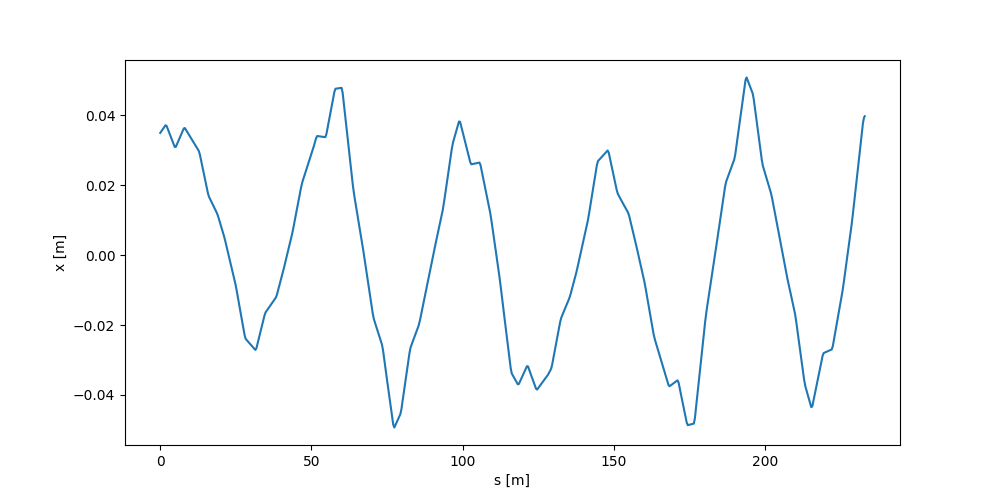

In [11]:
# Plot s vs x for the three last turns

plt.close('all')
plt.figure(figsize=(10,5))
plt.plot(s,rec_x)
plt.ylabel('x [m]')
plt.xlabel('s [m]')